In [1]:
import pandas as pd
import numpy as np
from scipy.stats import uniform
import matplotlib.pyplot as plt

In [2]:
#in the absence of any data, an expert may still have strong opinions regarding 
#the signatures of the various states of the system. The "plotmarkovlabels" function defines only some
#states of the system and this list can easily be expanded. As S, F1, F2, F3, F4 are dichotomous, 32 system 
#states may be defined in principle. As F2 and F3 are deemed mutually exclusive, 24 system states remain


In [3]:
# load the model inferred from engineering expertise (and not inferred from a data set!)
# the engineering expertise has been captured in a table that defines the possible system states, given some voltages and a switch position
# as this model does not require a history, the blocks below merely "massage" the data to a convenient format during deployment.


In [4]:
#load the representation of the engineering expertise in a pandas dataframe

df_dl = None

# this data set represents the system during deployment
df_dl =pd.read_excel("C:/Users/Admin/Pythonprojects/RAMS/data/Arduino_trainingset_3VarsMarkov.xlsx", index_col=0)
#df_dl = pd.read_excel("https://raw.githubusercontent.com/chrisrijsdijk/RAMS/master/data/Arduino_trainingset_3VarsMarkov.xlsx", index_col=0)

In [5]:
# check the datatypes in the dataframe to verify that all voltages are floats]

df_dl = df_dl.astype('float64', errors="ignore") #it appears that that VoltageA2 came in as an integer and that sucks...
df_dl.dtypes

S     float64
V0    float64
V1    float64
F1     object
F2     object
F3     object
F4     object
dtype: object

In [6]:
# dump the datalabels in a dictionary that will be used to retrieve the design labels

dict_dl =  df_dl.groupby(['F1','F2','F3','F4']).sum().to_dict('index')

#the keys:   a list of states (F1, F2, F3, F4)
#the values: dictionaries of the structure {'S': s, 'V0':v0, 'V1':v1}


In [7]:
# this function defines and plots the "Markov" labels

def plotmarkovlabels(ax):
    
    dum0 = df_dl.groupby(['F1','F2','F3','F4','S']).mean().reset_index()
    for i in dum0.index:
        cond = (
            df_dl.loc[:,'S']==dum0.loc[i,'S']) & (
            df_dl.loc[:,'F1']==dum0.loc[i,'F1']) & (
            df_dl.loc[:,'F2']==dum0.loc[i,'F2']) & (
            df_dl.loc[:,'F3']==dum0.loc[i,'F3']) & (
            df_dl.loc[:,'F4']==dum0.loc[i,'F4'])
        S = df_dl.loc[cond,'S']
        V0 = df_dl.loc[cond,'V0']
        V1 = df_dl.loc[cond,'V1']
        ax.scatter3D(V0,V1,S, zdir='z', color=str(i/len(dum0.index)), marker='v', 
                     label = 'S='+str(
                         dum0.loc[i,'S'])+',F1='+str(
                         dum0.loc[i,'F1'])+',F2='+str(
                         dum0.loc[i,'F2'])+',F3='+str(
                         dum0.loc[i,'F3'])+',F4='+str(
                         dum0.loc[i,'F4'])+' Markov', 
                     s=100*i+50)


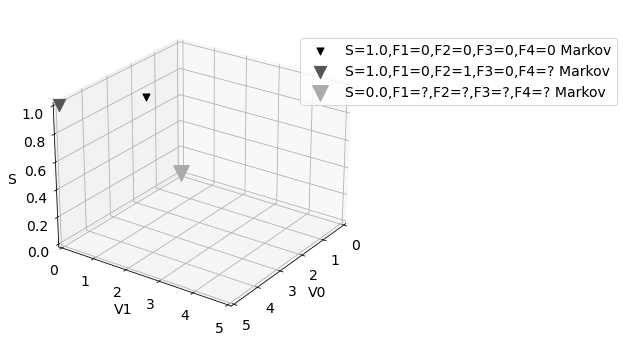

In [8]:
# Dump the plot

fig = plt.figure(figsize = (6,6))
plt.rcParams['font.size']=14
ax = fig.add_subplot(1,1,1, projection='3d')

plotmarkovlabels(ax)

ax.set_xlabel('V0'), ax.set_ylabel('V1'),ax.set_zlabel('S')
ax.set_xlim(0,5),    ax.set_ylim(0,5),   ax.set_zlim(0,1)
ax.set_title('')
ax.legend(loc='right', bbox_to_anchor=(1.8, 0.8))
ax.view_init(elev=25, azim=35)#, roll=0)


In [9]:
#the script below will load a labelled dataset and apply RF-classification to it...

In [10]:
#load some data in a pandas dataframe

df = None

# this data set represents the system during deployment

df =pd.read_excel("C:/Users/Admin/Pythonprojects/RAMS/data/Arduino_trainingset_3Vars.xlsx", index_col=0)
#df = pd.read_excel("https://raw.githubusercontent.com/chrisrijsdijk/RAMS/master/data/Arduino_trainingset_3Vars.xlsx", index_col=0)

In [11]:
# check the datatypes in the dataframe to verify that all columns are numerical

df.dtypes

S       int64
V0    float64
V1    float64
F1      int64
F2      int64
F3      int64
F4      int64
dtype: object

In [12]:
# get a preview on the data

#df.head(3)
df.describe()


,S,V0,V1,F1,F2,F3,F4
count,251.000000,251.000000,251.000000,251.000000,251.000000,251.0,251.000000
mean,0.565737,1.854535,0.979364,0.187251,0.091633,0.0,0.219124
std,0.496650,2.059786,1.473071,0.390892,0.289084,0.0,0.414479
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,1.000000,0.600586,0.000000,0.000000,0.000000,0.0,0.000000
75%,1.000000,3.334961,1.484375,0.000000,0.000000,0.0,0.000000
max,1.000000,4.995117,4.995117,1.000000,1.000000,0.0,1.000000


In [13]:
# this function defines and plots the "training" labels

def plottraininglabels(ax):
    
    dum0 = df.groupby(['F1','F2','F3','F4','S']).mean().reset_index()
    for i in dum0.index:
        cond = (
            df.loc[:,'S']==dum0.loc[i,'S']) & (
            df.loc[:,'F1']==dum0.loc[i,'F1']) & (
            df.loc[:,'F2']==dum0.loc[i,'F2']) & (
            df.loc[:,'F3']==dum0.loc[i,'F3']) & (
            df.loc[:,'F4']==dum0.loc[i,'F4'])
        S = df.loc[cond,'S']
        V0 = df.loc[cond,'V0']
        V1 = df.loc[cond,'V1']
        ax.scatter3D(V0,V1,S, zdir='z', color=str(i/len(dum0.index)), marker='.', 
                     label = 'S='+str(
                         dum0.loc[i,'S'])+',F1='+str(
                         dum0.loc[i,'F1'])+',F2='+str(
                         dum0.loc[i,'F2'])+',F3='+str(
                         dum0.loc[i,'F3'])+',F4='+str(
                         dum0.loc[i,'F4'])+' Training', 
                     s=100*i+50)
    

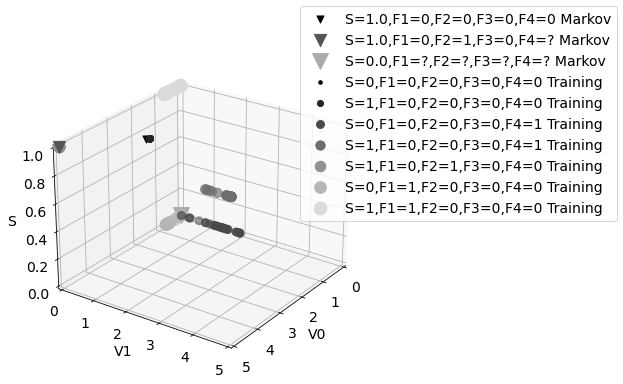

In [14]:
# Dump the plot

fig = plt.figure(figsize = (6,6))
plt.rcParams['font.size']=14
ax = fig.add_subplot(1,1,1, projection='3d')

plotmarkovlabels(ax)
plottraininglabels(ax)

ax.set_xlabel('V0'), ax.set_ylabel('V1'),ax.set_zlabel('S')
ax.set_xlim(0,5),    ax.set_ylim(0,5),   ax.set_zlim(0,1)
ax.set_title('')
ax.legend(loc='right', bbox_to_anchor=(1.8, 0.8))
ax.view_init(elev=25, azim=35)#, roll=0)


In [15]:
# make a dictionary that maps the dummies to T(rue) F(alse) strings

#failure_dict = {}

#failure_dict["F1"] = {0: "F, ", 1:"T, "}
#failure_dict["F2"] = {0: " F, ", 1:" T, "}
#failure_dict["F3"] = {0: " F, ", 1:" T, "}
#failure_dict["F4"] = {0: " F, ", 1:" T, "}


In [16]:
#In the following blocks the random forest model will be inferred using sklearn
#This RF model should predict a fault from voltage readings and the switch position...

#the steps are:
# define the response variables and convert them into an np.array
# define the explanatory variables
# impute data in case of NaN's by using K nearest neighbours
# define and fit the model
# plot the importance of the various explanatory variables using Gini importance

#I deliberately chose not to partition into a training set and a test set as I just validate the models using fresh input from the process

from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.inspection import permutation_importance

In [17]:
# define the response variables and convert them into an np.array
# note that each fault F1,...,F6 is a classifier that should be predicted
    
y_F1 = np.array(df["F1"])
y_F2 = np.array(df["F2"])
y_F3 = np.array(df["F3"])
y_F4 = np.array(df["F4"])


In [18]:
# define the explanatory variables
# note that the voltages and the switch position are the explanatory variables for the faults F1,...,F6

X=df.iloc[:,[0,1,2]]                 #the order of the columns has just been changed for graphical convenience
X_names=df.iloc[:,[0,1,2]].columns   #load a string of column names to label the output of the random forest model afterwards...

X_names

Index(['S', 'V0', 'V1'], dtype='object')

In [19]:
# impute data in case of NaN's by using K nearest neighbours
# the imputer also transforms X from a pd.DataFrame to a np.array as required for sklearn

imputer = KNNImputer(n_neighbors=5, weights="distance")
X=imputer.fit_transform(X)

In [20]:
# define and fit the model
# for each fault F1,...F6, a dedicated model has been defined
# not much thought has been spent on the choice of the model parameters

#define the model parameters of each fault F1,...,F6
rf_F1 = RandomForestClassifier(n_estimators = 40, criterion="gini",random_state = None)
rf_F2 = RandomForestClassifier(n_estimators = 40, criterion="gini",random_state = None)
rf_F3 = RandomForestClassifier(n_estimators = 40, criterion="gini",random_state = None)
rf_F4 = RandomForestClassifier(n_estimators = 40, criterion="gini",random_state = None)

#fit the models...
rf_F1.fit(X, y_F1)
rf_F2.fit(X, y_F2)
rf_F3.fit(X, y_F3)
rf_F4.fit(X, y_F4)


RandomForestClassifier(n_estimators=40)

In [21]:
# plot the importance of the various explanatory variables using Gini importance
# Gini importance is a number between zero and one, the heigher the Gini importance the better the explanatory variable can predict the failure y 

#remarks: 
# Do the most important predictors for F2, F4 and F6 from the RF-model correspond with engineering expertise?
# F1 is not in the data set
# try to understand why the RF models deem S1 as most predictive for F3, F5...
# from the above observations you may understand the impact of an incomplete data set.

featureImportances = np.array([rf_F1.feature_importances_, 
                               rf_F2.feature_importances_, 
                               rf_F3.feature_importances_, 
                               rf_F4.feature_importances_])

pd.DataFrame(featureImportances, columns = X_names, index = ["F1","F2","F3","F4"])

,S,V0,V1
F1,0.250527,0.621817,0.127656
F2,0.074155,0.567617,0.358227
F3,0.000000,0.000000,0.000000
F4,0.049415,0.153811,0.796774


In [22]:
#In the following blocks the k-means cluster model will be inferred using sklearn
#This k-means cluster model should detect voltage readings and switch positions that are very far away from the training set

#the steps are:
# define the explanatory variables
# impute data in case of NaN's by using K nearest neighbours
# rescale the data
# define the model and fit it to the data
# present the cluster means

#I deliberately chose not to partition into a training set and a test set as I just validate the models using fresh input from the process

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer

In [23]:
# define the cluster variables
# this step should be identical to the corresponding one in the RF-model

X=df.iloc[:,[0,1,2]]                 #the order of the columns has just been changed for graphical convenience
X_names=df.iloc[:,[0,1,2]].columns   #load a string of column names to label the output of the random forest model afterwards...

X_names

Index(['S', 'V0', 'V1'], dtype='object')

In [24]:
# impute data in case of NaN's by using K nearest neighbours
# the imputer also transforms X from a pd.DataFrame to a np.array as required for sklearn
# this step should be identical to the corresponding one in the RF-model

imputer = KNNImputer(n_neighbors=5, weights="distance")
X=imputer.fit_transform(X)

In [25]:
# rescale the data
#the choice of the standard scaler is arbitrary and eventually omissible
#the standard scaler transforms the data to z = (data - mean)/ standard devation
#running on unscaled data will make the voltages much more important than the switch as the voltages range over [0,5] and the switch over (0,1)

#set eventually some parameters of the standardscaler
scaler=StandardScaler()

#transform the data X to Z. Here, X will just be overwritten
X = scaler.fit_transform(X)

#print(scaler.mean_)

In [26]:
# prepare an elbow plot to visually determine a feasible number of clusters
#this step is essentially superfluous as deep knowledge about the number of clusters exists. It is just to show the spread reduction as k increases
#the elbow plot shows that variance within the clusters has indeed become ignorable at k>6

inertia = []
K = range(1,8)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    inertia.append(kmeanModel.inertia_)

C:\Users\Admin\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


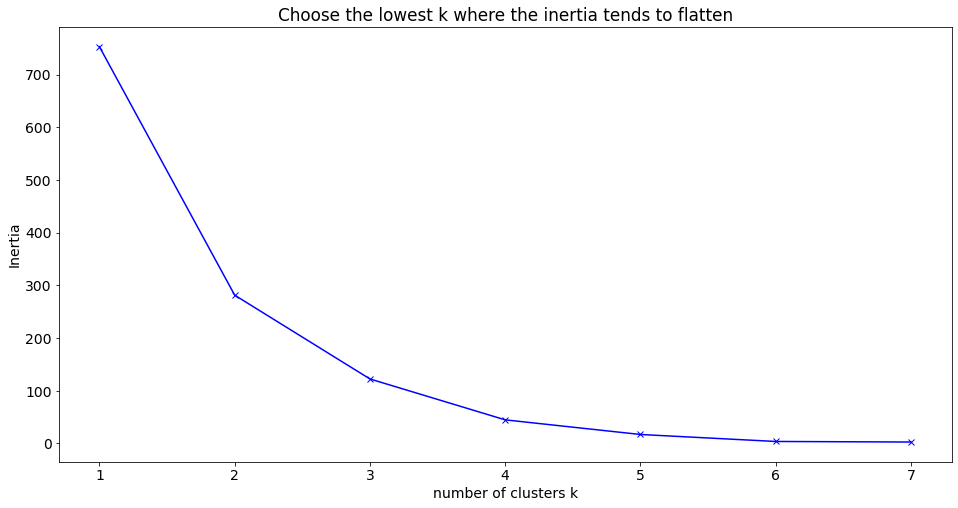

In [27]:
#create the elbow plot

plt.figure(figsize=(16,8))
plt.plot(K, inertia, 'bx-')
plt.xlabel('number of clusters k')
plt.ylabel('Inertia')
plt.title('Choose the lowest k where the inertia tends to flatten')
plt.show()

In [28]:
# define the model and fit it to the data

#define the model
k=6            #specify the number of clusters k. Here it is known that 6 system states have been in the data set
kmeanModel = KMeans(n_clusters=k)

#fit the model
kmeanModel.fit(X)
#kmeanModel.predict(X)

KMeans(n_clusters=6)

In [29]:
# present the cluster means
#remarks
# can you recognise the fact that F1 is not in the data set?
# can you recognise that F3 and F5 only occurred simultaneously in the data set?
# what would be your conclusion if the faults F1,...,F6 would scatter over many rows?
# do the cluster means that allude to faults correspond with engineering judgement?

#just add a label to the original data
df["clusterlabels"]=kmeanModel.labels_

#group the original data by the assigned clusterlabel and calculate the mean
dfclustermeans=df.groupby("clusterlabels").mean()
dfclustermeans


,S,V0,V1,F1,F2,F3,F4
clusterlabels,,,,,,,
0,0.0,0.055357,0.018818,0.168539,0.0,0.0,0.089888
1,1.0,3.333740,1.482829,0.000000,0.0,0.0,0.000000
2,1.0,4.995117,4.753328,0.000000,0.0,0.0,1.000000
3,1.0,0.336914,0.000000,1.000000,0.0,0.0,0.000000
4,1.0,4.995117,0.000000,0.000000,1.0,0.0,0.000000
5,0.0,0.000000,1.341797,0.000000,0.0,0.0,1.000000


In [30]:
# this function defines and plots the "cluster" labels

def plotclusterlabels(ax):
    
    dum1 = df.iloc[:,[1,2,0,-1]]
    
    for i in list( np.sort(dum1.iloc[:,-1].unique()) ):
        ax.scatter3D(dum1.loc[dum1.iloc[:,-1]==i,'V0'], 
                     dum1.loc[dum1.iloc[:,-1]==i,'V1'], 
                     dum1.loc[dum1.iloc[:,-1]==i,'S'],
                     zdir='z', color=str((i)/len(dum1.iloc[:,-1].unique())),
                     label= 'cluster'+str(i),
                     marker='o', s=20*i+5)
    

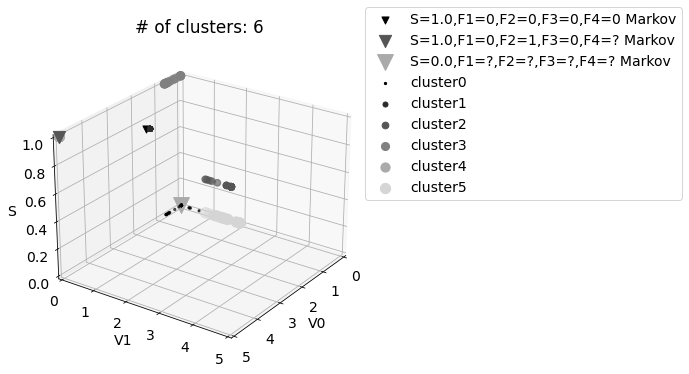

In [31]:
# Plot the training data in a graph AND project the cluster means on them

fig = plt.figure(figsize = (6,6))
plt.rcParams['font.size']=14

# Dump the plot
ax = fig.add_subplot(1,1,1, projection='3d')

plotmarkovlabels(ax)
plotclusterlabels(ax)

ax.set_xlabel('V0'), ax.set_ylabel('V1'),ax.set_zlabel('S')
ax.set_xlim(0,5),    ax.set_ylim(0,5),   ax.set_zlim(0,1)
ax.set_title('# of clusters: '+ str(k) )
ax.legend(loc='right', bbox_to_anchor=(2, 0.8))

ax.view_init(elev=25, azim=35)#, roll=0)


In [32]:
#The blocks above prepared an rf-model, a k-means clustering model and an expert model that will now be deployed. This means that the
#Arduino controller will capture new data from the process under investigation and that this new data will be evaluated by these models.
#As the observers tend to have a strong opinion about the true system state while observing the process, they could evaluated whether the
#three models corresponds with their beliefs.

#The steps of the deployment are:
# connect with Arduino
# read write the serial connection at a given sampling rate
# start to control the Arduino while collecting the data
# close the serial connection

In [33]:
# display the RF output

def displayRF(dum5, result):

    # let the inferred random forest models evaluate the incoming data
    dum_F1 = rf_F1.predict(dum5)
    dum_F2 = rf_F2.predict(dum5)
    dum_F3 = rf_F3.predict(dum5)
    dum_F4 = rf_F4.predict(dum5)
    result = ( dum_F1[0], dum_F2[0], dum_F3[0], dum_F4[0] )
    return result
    

In [34]:
# display DL output

def displayDL(dum5, result):
    
    dum = {                                                          #generate a dictionary
        k: np.linalg.norm(                                           #determine the difference...
            np.array(dum5) - np.array([list(dict_dl[k].values())])   #between the reading and the values of ...
        )   for k,v in list(dict_dl.items())                         #the various design labels
    }
    result = min(dum, key=dum.get)                                            #get the key where the difference is minimal
    return result
    

In [35]:
import serial
import time
import keyboard

In [36]:
# connect with Arduino

ser = serial.Serial('COM3', 9600, timeout=1) #check whether the Arduino is really connected with COM3 or adjust the code to the correct COM
                                             #check at settings and check whether Arduino is a connected device
time.sleep(2)

In [37]:
# read write the serial connection at a given sampling rate

def write_read(x):                  #this function takes an input x, which is a switch command and it returns data from the Arduino
    ser.write(bytes(x, 'utf-8'))    #pass the command to Arduino by the serial connection
    time.sleep(0.05)                #give it some time
    data = ser.readline()           #take data from Arduino
    return data                     #return the data to be processed further

In [38]:
# start to control the Arduino while collecting the data

i= True                                       #this boolean allows to interrupt the data collection
num ='0'
result =()

print("Press <1> to switch power on")
print("Press <0> to switch power off")
print("Press <q> to quit")
print(".............................")
print("[  S, V_0, V_1, F1,  F2,  F3,  F4]")

while i:                                      # making a loop continues as long as i is true. This loop involves a cycle of reading and evaluating data
    
    if keyboard.is_pressed('q'):              # if key 'q' is pressed 
        print('')
        print('You Pressed <q>uit!')
        i = False                             # finishing the loop
        
    elif keyboard.is_pressed('0'):            # if key '0' is pressed
        num = '0'                             # this represents the opening of the switch
        
    elif keyboard.is_pressed('1'):            # if key '1' is pressed
        num = '1'                             # this represents the closing of the switch
        
    else:
        value = write_read(num)               # if user did anything else then pressing 'q','0' or '1', the loop proceeds with collecting data

        dummy = value.decode().rstrip().split()                                     # transform the byte values that came in...
        dum4 = np.array([[int(dummy[0])]])                                          # .. to a binary for S and ...
        dum5 = np.array([np.append(dum4,[int(j)/1023*5 for j in dummy[1:]]  )])     #...some floats for V

# let the inferred k-means clustering model evaluate the incoming data
        dum6 = scaler.transform(dum5)                   # scaler should be identical to the scaler used during the training of the model!
        dum1 = kmeanModel.predict(dum6)                 # dum1 is the label of the nearest clustermean
        dum2 = kmeanModel.cluster_centers_[dum1]        # dum2 is an array of coordinates of the nearest clustermean
        dum3 = scaler.inverse_transform(dum2)           # reschale the coordinates back, to compare them with the data that came in

# depending on the applicability of the engineering model and the k-means models, different things will be dumped to screen
# both of these models either apply or do not apply and therefore there are 2^2=4 different screen dumps. Applicability means that:
#  the distance between the incoming data and the data from any label in the expert model should be <0.7
#  the distance betwwen the incoming data and the assigned k-means cluster should be <0.7

    if np.linalg.norm(dum5-dum3)<=0.7:
        uitkomstRF = displayRF(dum5, result)
        
    else:
        uitkomstRF = ('distance to nearest training data is too large')
              

    if (min(                                                                 #determine the minimum...
        [                                                                #from a list of...
            np.linalg.norm(                                              #differences...
                np.array(dum5) - np.array([list(dict_dl[k].values())])   #between the reading and the values in ...
                )   for k in list(dict_dl.keys())                        #dict_dl
            ]
        )
    )<=0.7:
        uitkomstDL = displayDL(dum5, result)
        
    else:
        uitkomstDL = ('distance to nearest design label is too large')
        
    print(str(pd.to_datetime(round(time.time(), 0),unit = 's')),
          uitkomstRF, uitkomstDL, list(dum5[0]), end = "\r")
        
    time.sleep(0.01)

ser.close()       #close the serial port when the reading is stopped. If not done, reconnection with the Arduino is not possible

Press <1> to switch power on
Press <0> to switch power off
Press <q> to quit
.............................
[  S, V_0, V_1, F1,  F2,  F3,  F4]
2022-11-18 16:21:19 (0, 0, 0, 0) ('?', '?', '?', '?') [0.0, 0.0, 0.0], 1.4222873900293256]
You Pressed <q>uit!


# 

# 